In [1]:
import json 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
bits = "8" # "8" or "4"
model_name = ["mistralai/Mixtral-8x22B-Instruct-v0.1","01-ai/Yi-1.5-9B-Chat","mistralai/Mixtral-8x7B-Instruct-v0.1","Qwen/Qwen1.5-7B-Chat","meta-llama/Meta-Llama-3-8B-Instruct"]
i = 0

results=[]
coverage_raw=[]


#with open("./scripts/higher_temp_we_gridout_"+bits+"bit_"+"_".join(model_name[4].split("/"))+".jsonl", "r") as f:
with open("./gridsearch_output/test.jsonl", "r") as f:
    for idx, line in enumerate(f):
        line = json.loads(line)
        if idx%9==0:
            results.append(line)
        #coverage_raw.append(len(line["aligned_output"])/len(line["truncated_input"]))

#coverage_all = [[] for i in range(int(len(coverage_raw)/50)+1)]
#coverage_avg = []

#print(len(coverage_raw))

'''for i in range(int(len(coverage_raw)/50)+1):
    for j in range(50):
        try:
            coverage_all[i].append(coverage_raw[i*50+j])
        except:
            None

coverage_avg = [sum(elt)/len(elt) for elt in coverage_all]
print(coverage_raw[:100])'''

'for i in range(int(len(coverage_raw)/50)+1):\n    for j in range(50):\n        try:\n            coverage_all[i].append(coverage_raw[i*50+j])\n        except:\n            None\n\ncoverage_avg = [sum(elt)/len(elt) for elt in coverage_all]\nprint(coverage_raw[:100])'

In [4]:
cer = []
window_size = []
mirostat_tau=[]
extend_gap_score=[]
open_gap_score=[]
temperature=[]
overlap_percentage=[]

lowest_score = 1
lowest_score_index = 0

for index, elt in enumerate(results):
    try:
        #time.append(elt["time taken"])
        #tokens.append(elt["total tokens generated"])
        
        cer.append(elt["scores"]["cer"])
    
        if elt["scores"]["cer"] < lowest_score:
            lowest_score = elt["scores"]["cer"]
            lowest_score_index = index
    
        overlap_percentage.append(elt["parameters"]["overlap_percentage"])
        extend_gap_score.append(elt["parameters"]["extend_gap_score"])
        open_gap_score.append(elt["parameters"]["open_gap_score"])
        mirostat_tau.append(elt["parameters"]["mirostat_tau"])
        temperature.append(elt["parameters"]["temperature"]) 
        window_size.append(elt["parameters"]["window_size"])
        
        #y.append(elt["total tokens generated"]/elt["time taken"])
    except:
        None

print("lowest score at index:", index)

lowest score at index: 55


<bound method Series.max of 0     0.545934
1     0.818901
2     0.755604
3     0.240440
4     0.982857
5     0.865055
6     0.465934
7     0.185495
8     1.203956
9     0.174066
10    0.035604
11    0.039560
12    0.036484
13    0.392967
14    0.152527
15    0.290989
16    1.017582
17    1.061978
18    0.036044
19    0.036484
20    0.221978
21    0.036044
22    0.035604
23    0.035165
24    0.142857
25    0.036044
26    0.253187
27    0.614945
28    0.037363
29    0.646154
30    0.043516
31    0.036484
32    0.027253
33    0.023297
Name: character_error_rate, dtype: float64>


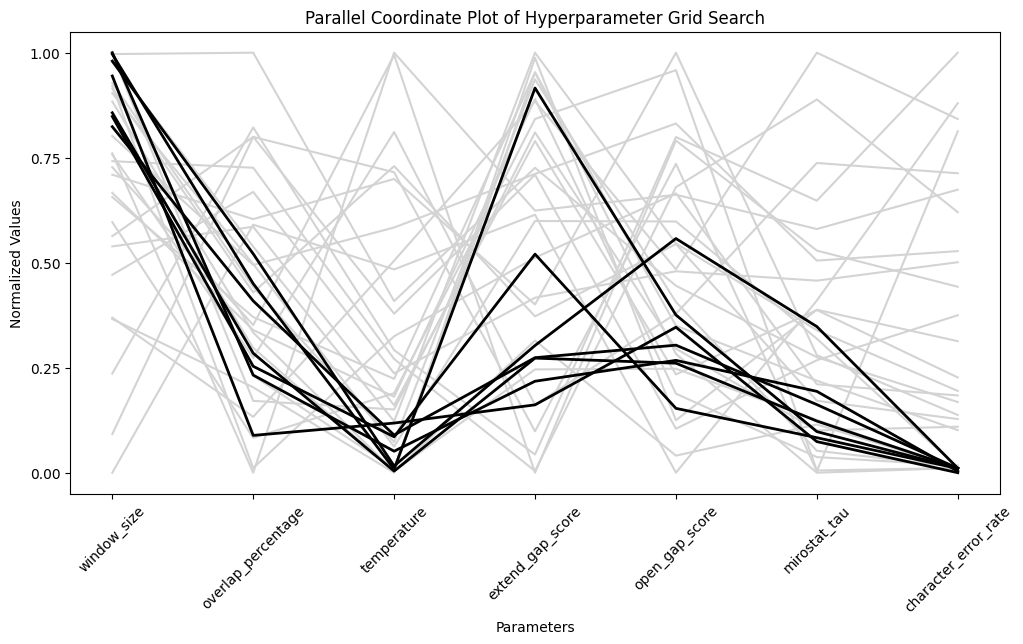

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'overlap_percentage': overlap_percentage,
    'temperature': temperature,
    'extend_gap_score': extend_gap_score,
    'open_gap_score': open_gap_score, 
    'mirostat_tau': mirostat_tau,
    'character_error_rate': cer, 
    
}

'''print(len(window_size))
print(len(do_sample))
print(len(temperature))
print(len(beam_search))
print(len(num_beams))
print(len(wer))
print(len(coverage_avg))'''

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data for plotting purposes
df_normalized = df.copy()
maxVal = 1.0
df_normalized['character_error_rate'].where(df_normalized['character_error_rate'] <= maxVal, maxVal)

print(df_normalized['character_error_rate'].max)
for column in df_normalized.columns:
    if (df_normalized[column].dtype != bool  and column !='coverage'): #and column != 'character_error_rate')
        df_normalized[column] = (df_normalized[column] - df_normalized[column].min()) / (df_normalized[column].max() - df_normalized[column].min())

# Define a function to convert boolean to int for plotting
#df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
#df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)

# Sort the DataFrame based on character error rate
df_sorted = df_normalized.sort_values(by='character_error_rate')

# Split the DataFrame into two parts
df_grey = df_sorted[7:]
df_black = df_sorted[:7]

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the grey lines first
for i in range(len(df_grey)):
    ax.plot(df_grey.columns, df_grey.iloc[i], color='lightgrey')

# Plot the black lines on top
for i in range(len(df_black)):
    ax.plot(df_black.columns, df_black.iloc[i], color='black', linewidth=2)

# Customize the axis labels to show actual values
for i, column in enumerate(df.columns):
    values = df[column]
    normalized_values = df_normalized[column]
    tick_positions = np.linspace(0, 1, num=5)
    tick_labels = np.linspace(0, 1, num=5)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{label:.2f}" for label in tick_labels])

# Label the plot
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()


In [7]:
print(df_black)

    window_size  do_sample  temperature  beam_search  num_beams  \
2      0.615108          0     0.000000            0        0.0   
1      0.989209          0     0.000000            0        0.0   
0      1.000000          0     0.000000            0        0.0   
33     0.147482          0     0.000000            0        0.0   
34     0.147482          0     0.000000            0        0.0   
3      0.219424          1     0.042971            1        0.8   
4      0.219424          1     0.042971            1        0.8   

    character_error_rate  coverage  
2               0.102963  0.957631  
1               0.107009  0.959599  
0               0.108050  0.960375  
33              0.149485  0.804292  
34              0.149485  0.784856  
3               0.153287  0.991923  
4               0.153287  0.616069  


/usr/local/lib64/python3.9/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (34). n_quantiles is set to n_samples.
  warnings.warn(


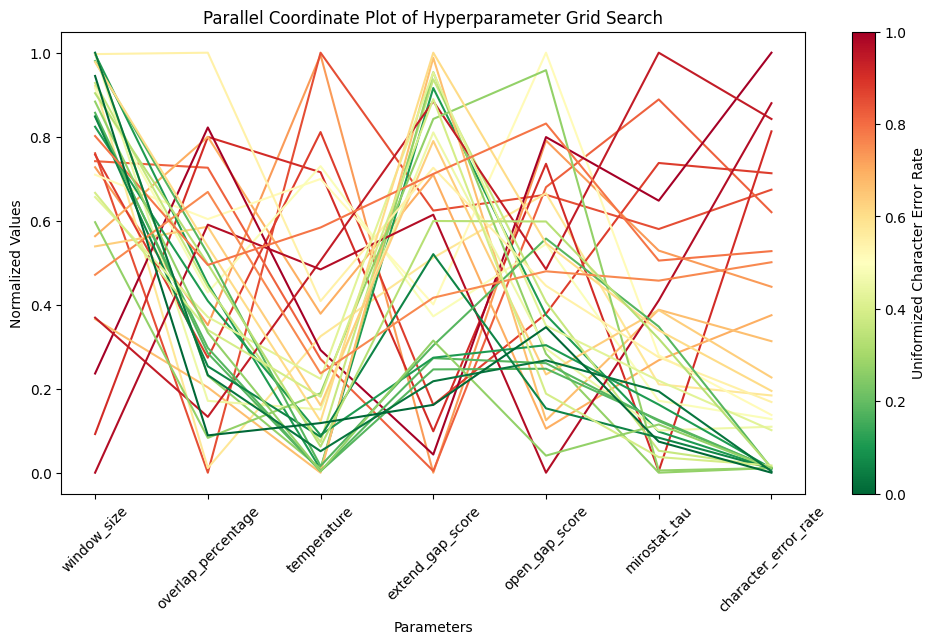

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import matplotlib.colors as mcolors
# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'overlap_percentage': overlap_percentage,
    'temperature': temperature,
    'extend_gap_score': extend_gap_score,
    'open_gap_score': open_gap_score, 
    'mirostat_tau': mirostat_tau,
    'character_error_rate': cer, 
    
}


# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data (excluding boolean columns) for better visualization
for column in df.columns:
    if df[column].dtype != bool:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# Define a function to convert boolean to int for plotting
#df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
#df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)


# Use QuantileTransformer to normalize the character error rate
quantile_transformer = QuantileTransformer(output_distribution='uniform')
df['character_error_rate_normalized'] = quantile_transformer.fit_transform(df[['character_error_rate']])

# Determine the colors based on the normalized character error rate
norm = plt.Normalize(df['character_error_rate_normalized'].min(), df['character_error_rate_normalized'].max())
colors = plt.cm.RdYlGn_r(norm(df['character_error_rate_normalized']))

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the parallel coordinates
for i in range(len(df)):
    ax.plot(df.columns[:-1], df.iloc[i, :-1], color=colors[i])

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Uniformized Character Error Rate')

# Label the axes
plt.xticks(rotation=45)
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()
